# Activity 08 - Support Vector Machines

***
##### CS 434 - Dating Mining and Machine Learning
##### Oregon State University-Cascades
***

# Load packages

In [0]:
import ssl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
ssl._create_default_https_context = ssl._create_unverified_context
pd.options.mode.chained_assignment = None

In [0]:
# helper function to iterate character range
def char_range(c1, c2):
    """Generates the characters from `c1` to `c2`, inclusive."""
    for c in range(ord(c1), ord(c2)+1):
        yield chr(c)

# Dataset

[Vehicle Silhouettes Data Set](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29)

The purpose is to classify a given silhouette as one of four types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.

### Features

* **compactness** : (average perim)**2/area
* **circularity** : (average radius)**2/area
* **distance circularity** : area/(av.distance from border)**2
* **radius ratio** : (max.rad-min.rad)/av.radius
* **pr.axis aspect ratio** : (minor axis)/(major axis)
* **max.length aspect ratio** : (length perp. max length)/(max length)
* **scatter ratio** : (inertia about minor axis)/(inertia about major axis)
* **elongatedness** : area/(shrink width)**2
* **pr axis** : rectangularity area/(pr.axis length*pr.axis width)
* **max length** : rectangularity area/(max.length*length perp. to this)
* **scaled variance** : (2nd order moment about minor axis)/area
along major axis
* **scaled variance** : (2nd order moment about major axis)/area
along minor axis
* **scaled radius of gyration** : (mavar+mivar)/area
* **skewness about major axis** : (3rd order moment about major axis)/sigma_min**3

* **skewness about minor axis** : (3rd order moment about minor axis)/sigma_maj**3

* **kurtosis about minor axis** : (4th order moment about major axis)/sigma_min**4
minor axis

* **kurtosis about major axis** : (4th order moment about minor axis)/sigma_maj**4
major axis

* **hollows ratio** : (area of hollows)/(area of bounding polygon)


### Class Label




* **vehicle** : four vehicles 
   * `'OPEL'`
   * `'SAAB'`
   * `'BUS'`
   * `'VAN'`

### File information

Files: `xaa.dat`, `xab.dat`, ... `xai.dat` (note the range `'a'` to `'i'`)

In [0]:
url_prefix = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/vehicle/xa'
url_suffix = '.dat'
header = ['compactness','circularity','distance circularity','radius ratio','pr axis aspect ratio','max length aspect ratio','scatter ratio','elongatedness','pr axis rectangularity','max length rectangularity','scaled variance along major axis','scaled variance along minor axis','scaled radius of gyration','skewness about major axis','skewness about minor axis','kurtosis about minor axis','kurtosis about major axis','hollows ratio','vehicle']

*** 
# Exercise #1 - Load data
*** 

##### 1.1 Read the file `xaa.dat` into new dataframe `df`.

* build the url from the prefix, char `'a'`, and suffix
* mind your delimiter
* use `index_col=False`

In [104]:
# read xaa.data into df
df = pd.read_csv(url_prefix + 'a' + url_suffix, delimiter=' ', index_col=False, names=header)
df

,compactness,circularity,distance circularity,radius ratio,pr axis aspect ratio,max length aspect ratio,scatter ratio,elongatedness,pr axis rectangularity,max length rectangularity,scaled variance along major axis,scaled variance along minor axis,scaled radius of gyration,skewness about major axis,skewness about minor axis,kurtosis about minor axis,kurtosis about major axis,hollows ratio,vehicle
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,80,37,57,116,55,6,125,54,18,125,142,229,132,81,8,5,178,184,opel
90,104,55,107,222,68,11,218,31,24,173,232,703,229,71,3,10,188,199,saab
91,94,38,84,158,55,9,169,39,20,130,196,430,155,69,9,15,190,195,opel
92,104,52,100,191,59,9,197,33,23,158,218,583,234,70,10,10,191,198,saab


##### 1.2 Read the other files `xab.dat`, etc. and add to your dataframe `df`.

In [105]:
# load the dataset into a dataframe
for c in char_range('b', 'i'):
  d = pd.read_csv(url_prefix + c + url_suffix, delimiter=' ', index_col=False, names=header)
  df = df.append(d, ignore_index=True)
df

,compactness,circularity,distance circularity,radius ratio,pr axis aspect ratio,max length aspect ratio,scatter ratio,elongatedness,pr axis rectangularity,max length rectangularity,scaled variance along major axis,scaled variance along minor axis,scaled radius of gyration,skewness about major axis,skewness about minor axis,kurtosis about minor axis,kurtosis about major axis,hollows ratio,vehicle
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,93,39,87,183,64,8,169,40,20,134,200,422,149,72,7,25,188,195,saab
842,89,46,84,163,66,11,159,43,20,159,173,368,176,72,1,20,186,197,van
843,106,54,101,222,67,12,222,30,25,173,228,721,200,70,3,4,187,201,saab
844,86,36,78,146,58,7,135,50,18,124,155,270,148,66,0,25,190,195,saab


##### 1.3 Describe your data

In [106]:
# describe the dataset
df.describe()

,compactness,circularity,distance circularity,radius ratio,pr axis aspect ratio,max length aspect ratio,scatter ratio,elongatedness,pr axis rectangularity,max length rectangularity,scaled variance along major axis,scaled variance along minor axis,scaled radius of gyration,skewness about major axis,skewness about minor axis,kurtosis about minor axis,kurtosis about major axis,hollows ratio
count,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.00000,846.000000,846.000000,846.000000,846.000000,846.000000
mean,93.678487,44.861702,82.088652,168.940898,61.693853,8.567376,168.839243,40.933806,20.582742,147.998818,188.625296,439.911348,174.70331,72.462175,6.377069,12.599291,188.932624,195.632388
std,8.234474,6.169866,15.771533,33.472183,7.888251,4.601217,33.244978,7.811560,2.592138,14.515652,31.394837,176.692614,32.54649,7.486974,4.918353,8.931240,6.163949,7.438797
min,73.000000,33.000000,40.000000,104.000000,47.000000,2.000000,112.000000,26.000000,17.000000,118.000000,130.000000,184.000000,109.00000,59.000000,0.000000,0.000000,176.000000,181.000000
25%,87.000000,40.000000,70.000000,141.000000,57.000000,7.000000,146.250000,33.000000,19.000000,137.000000,167.000000,318.250000,149.00000,67.000000,2.000000,5.000000,184.000000,190.250000
50%,93.000000,44.000000,80.000000,167.000000,61.000000,8.000000,157.000000,43.000000,20.000000,146.000000,178.500000,364.000000,173.00000,71.500000,6.000000,11.000000,188.000000,197.000000
75%,100.000000,49.000000,98.000000,195.000000,65.000000,10.000000,198.000000,46.000000,23.000000,159.000000,217.000000,587.000000,198.00000,75.000000,9.000000,19.000000,193.000000,201.000000
max,119.000000,59.000000,112.000000,333.000000,138.000000,55.000000,265.000000,61.000000,29.000000,188.000000,320.000000,1018.000000,268.00000,135.000000,22.000000,41.000000,206.000000,211.000000


Self Check
> There are 846 records.

*** 
# Exercise #3 - Train a Support Vector Machine
*** 

##### 2.1 Split `X` and `y`

In [0]:
# split to X and y
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

##### 2.2 Partition to train and test sets

* test proportion of 20%
* `random_state=1`
* stratify by `y`

In [0]:
# partition to train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

2.3 Print the shapes of your four sets

In [109]:
# print shapes of train and test
print(X_test.shape, X_train.shape, y_test.shape, y_test.shape)

(170, 18) (676, 18) (170,) (170,)


Self Check

In [0]:
assert len(y_train)==676 and len(y_test)==170

2.4 Create the pipeline 

* Name it `pipe_svm`
* Standardize
* Support Vector Machine: [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) 
  * with `random_state=1`
  * with `kernel='linear'`

In [111]:
# make an SVM pipeline
pipe_svm = make_pipeline(StandardScaler(), SVC(random_state=1, kernel='linear'))
pipe_svm

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability=False, random_state=1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

##### 2.5 Fit your `pipe_svm` with training data

In [112]:
# train the pipeline
pipe_svm.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability=False, random_state=1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

###### Self Check


```
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability=False, random_state=1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
```

*** 
# Exercise #3 - Test the model
*** 

##### 3.1 Predict the test set and save predictions as `y_pred`

In [115]:
# predict the test set and save as y_pred
y_pred = pipe_svm.predict(X_test)
y_pred

array(['van', 'van', 'saab', 'van', 'opel', 'opel', 'van', 'van', 'bus',
       'opel', 'van', 'van', 'opel', 'saab', 'opel', 'bus', 'van', 'saab',
       'saab', 'opel', 'opel', 'saab', 'saab', 'bus', 'saab', 'bus',
       'opel', 'van', 'saab', 'van', 'van', 'bus', 'opel', 'opel', 'saab',
       'van', 'opel', 'opel', 'opel', 'opel', 'saab', 'bus', 'saab',
       'van', 'bus', 'saab', 'saab', 'van', 'van', 'saab', 'saab', 'van',
       'bus', 'opel', 'opel', 'bus', 'saab', 'opel', 'van', 'bus', 'van',
       'opel', 'van', 'saab', 'saab', 'bus', 'van', 'opel', 'bus', 'saab',
       'van', 'bus', 'bus', 'opel', 'bus', 'van', 'bus', 'opel', 'saab',
       'bus', 'van', 'opel', 'van', 'opel', 'saab', 'van', 'opel', 'opel',
       'van', 'opel', 'bus', 'van', 'van', 'bus', 'van', 'bus', 'opel',
       'bus', 'bus', 'saab', 'opel', 'opel', 'van', 'opel', 'opel', 'bus',
       'saab', 'van', 'van', 'saab', 'saab', 'bus', 'van', 'saab', 'opel',
       'saab', 'van', 'van', 'opel', 'bus', 's

##### 3.2 From `y_pred`, count the number of predictions for each vehicle class 

In [122]:
# count the number of predictions by class
(unique, counts) = np.unique(y_pred, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[['bus' 43]
 ['opel' 46]
 ['saab' 36]
 ['van' 45]]


##### 3.3 Calculate the test accuracy

> Format your numbers nicely (e.g., 3 digits after the `.`).  
> We're not peasants. 

In [158]:
# print the accuracy score
# print('Test Accuracy: %.3f' % pipe_svm.score(X_test, y_test))
accuracy_score(y_test, y_pred)

0.8235294117647058

Self Check

In [0]:
assert abs(accuracy_score(y_train, pipe_svm.predict(X_train)) - 0.8254437869822485) < 0.001

##### 3.4 Calculate the precison, recall, and F$_1$ score

* Use `average='weighted'` as the multi-class strategy

In [142]:
# precision tp / (tp + fp)
# recall: tp / (tp + fn)
# f1: 2 tp / (2 tp + fp + fn)
print('precision: ', precision_score(y_test, y_pred, average='weighted'))
print('recall: ', recall_score(y_test, y_pred, average='weighted'))
print('f1: ', f1_score(y_test, y_pred, average='weighted'))

precision:  0.8255576042348183
recall:  0.8235294117647058
f1:  0.8214981578100539


##### 3.5 Graph the confusion matrix

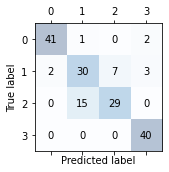

In [143]:
# graph a confusion matrix
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

*** 
# Exercise #4 - Parameter Grid Search
*** 

> Use the code for `GridSearchCV` from `Lecture 05`

##### 4.1 Search SVM parameters for best model

`GridSearchCV` with
* `refit=True`
* `cv=10`
* `n_jobs=-1`
* `scoring='accuracy'`

* `param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]`

* ```
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]
```

In [147]:
# tune hyperparameters with GridSearchCV and fit gs
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
gs = GridSearchCV(estimator=pipe_svm, 
                  param_grid = [{'svc__C': param_range, 
             'svc__kernel': ['linear']},
            {'svc__C': param_range, 
             'svc__gamma': param_range, 
             'svc__kernel': ['rbf']}], 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8404521510096575
{'svc__C': 1000.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


> Observe the score and the selected 'best params'

4.2 Select the best estimator from `gs` and save as `clf`

In [148]:
# get best estimator
clf = gs.best_estimator_

print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.812


4.3 Predict the test set with `clf`

In [152]:
# predict test set
clf.predict(X_test)

array(['van', 'van', 'saab', 'van', 'opel', 'opel', 'van', 'van', 'bus',
       'saab', 'van', 'van', 'opel', 'saab', 'opel', 'bus', 'van', 'saab',
       'saab', 'saab', 'saab', 'saab', 'saab', 'bus', 'saab', 'bus',
       'bus', 'van', 'opel', 'van', 'van', 'bus', 'opel', 'opel', 'opel',
       'van', 'opel', 'saab', 'opel', 'opel', 'opel', 'bus', 'opel',
       'van', 'van', 'opel', 'saab', 'opel', 'van', 'saab', 'saab', 'van',
       'bus', 'opel', 'opel', 'bus', 'saab', 'saab', 'van', 'bus', 'van',
       'opel', 'van', 'saab', 'saab', 'bus', 'saab', 'saab', 'bus',
       'saab', 'van', 'bus', 'bus', 'opel', 'saab', 'van', 'bus', 'opel',
       'saab', 'bus', 'van', 'opel', 'bus', 'opel', 'saab', 'van', 'saab',
       'opel', 'van', 'opel', 'bus', 'van', 'van', 'bus', 'van', 'opel',
       'opel', 'bus', 'bus', 'saab', 'saab', 'opel', 'van', 'opel',
       'opel', 'bus', 'saab', 'van', 'van', 'saab', 'opel', 'bus', 'bus',
       'opel', 'opel', 'opel', 'van', 'saab', 'saab', 'bus'

4.4 Print the test accuracy

In [160]:
# print the test accuracy
print('accuracy: ', accuracy_score(y_test, clf.predict(X_test)))

accuracy:  0.8117647058823529


> Did we do better? And by how much?

4.5 Graph the confusion matrix

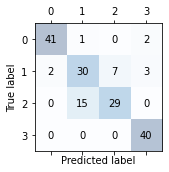

In [161]:
# graph a confusion matrix
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

<img src="https://66.media.tumblr.com/dded9d1a2bf2068f92af9f7a9b6b5451/tumblr_p6s3hbPzgV1vd8jsjo1_500.gifv" width="300">